# Caso Activación Tarjetas de Crédito - Grupo 5

## Fuente

In [ ]:
import pandas as pd
import numpy as np
tc = pd.read_csv("tc.txt")

## Inspección

In [ ]:
tc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7700 entries, 0 to 7699
Columns: 398 entries, IDCTA to flg_activacion_0_12
dtypes: float64(393), int64(2), object(3)
memory usage: 23.4+ MB


In [ ]:
tc.select_dtypes(include=['object'])

,rank_tip,cat_zona1,tipo_cliente
0,1.TARJERTAS,LIMA_ESTE,CLIENTE_B
1,1.TARJERTAS,CALLAO,CLIENTE_C
2,1.TARJETAS,JUNIN,CLIENTE_A
3,1.TARJERTAS,LORETO,CLIENTE_A
4,1.TARJERTAS,LIMA_NORTE,CLIENTE_A
...,...,...,...
7695,1.TARJERTAS,LIMA_PROV,CLIENTE_B
7696,1.TARJERTAS,LIMA_MODERNA,CLIENTE_C
7697,1.TARJERTAS,LIMA_SUR,CLIENTE_B
7698,1.TARJERTAS,LIMA_SUR,CLIENTE_A


In [ ]:
tc.head()

,IDCTA,rank_tip,xb_buro,cl_veh_mean_st,cat_zona1,atr_co_med_24,dist_ult1_atr_co_24_0_100,rt_bal_co_med_3_6,rt_atr_co_max_3_12,rt_atr_co_max_3_24,atr_hi_max_3_0,dist_ult1_atr_hi_24_0_0,rt_bal_hi_med_3_12,rt_bal_hi_med_6_12,num_tc_min_24,num_tc_sum_24,lincre_tc_max_24,lincre_tc_sum_24,flagpr_tc_sum_12,atr_tc_med_12,bal_tc_min_12,atr_tc_min_3,dist_primer_atr_tc_24_0,rt_atr_tc_max_6_24,rt_bal_tc_med_12_24,atr_max_3,atr_max_3_300,atr_max_12_300,atr_max_24_300,atr_min_6_300,bal_nhi_sum_12,varied_prod_24_300,varied_prod_3_0,varied_prod_6_300,rt_evol_3_24,rt_evol_rev_3_6,rt_evol_nhi_3_6,rt_evol_nhi_3_24,rt_util_3,rt_util_24,...,atrasomax_veh_6,ctdempreportadoclimax24,ctdempreportadoclimed24,ctdempreportadoclimed6,deudir12_deutot12,deudir24_deutot24,deudir3_deutot3,deudir6_deutot6,flg_rev_12,flg_tc_12,meses_activo_sf_bu_ma24_0,meses_rcc24,montoade_act24_max24_ind,montoade_act3_max6_s_hip,mtodeudamax24_mtodeudaactual,mtolintc_pro24,mtolintot_dmi0_pro6,mtototdeu_d_i_pro3,sf_num_cal_cpp24,sf1_sf24_ind_s_hip,sf6_sf24_ind_s_hip,sfent1_sfent24,sfent12_sfent24,sfent3_sfent24,sfent6_sfent24,utl_12_tc,utl_12_tc_v1,utl_24_tc,utl_3_tc,utl_6_tc,utl1_utl12_tc,utl1_utl24_tc,utlcs_12_tc_v1,utlcs_24,utlcs_24_tc_v1,utlcs_3_tc,utlcs_6_tc_v1,vecescontinuo,tipo_cliente,flg_activacion_0_12
0,27673401,1.TARJERTAS,-4.094333,-0.188999,LIMA_ESTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-99.0,3.0,2.500000,2.0,1.000000,0.994214,1.000000,1.000000,0.0,0.0,24.0,24.0,0.602219,0.788501,30828.0510,150.0000,0.000,13651.257,0.0,0.471396,0.572802,0.800000,1.000000,0.800000,0.800000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,CLIENTE_B,1
1,28186416,1.TARJERTAS,-4.430600,-0.793450,CALLAO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,12.0,23000.0,276000.0,12.0,0.0,-4.2900,0.0,NaN,NaN,1.00000,0.0,NaN,0.0,0.0,NaN,14858.56,1.0,0.0,0.0,-0.006929,1.000000,1.000000,-0.006929,-0.000187,0.053835,...,-99.0,6.0,4.791666,6.0,0.682168,0.750049,0.633727,0.657360,1.0,1.0,23.0,24.0,0.817119,0.341361,23812.4000,39645.1480,45886.910,200392.810,0.0,1.748536,1.491365,1.252174,1.182609,1.252174,1.252174,0.059563,0.059563,0.058629,0.046402,0.057392,0.025723,0.026133,0.148253,0.129292,0.129292,0.181865,0.180981,24.0,CLIENTE_C,1
2,27798103,1.TARJETAS,-4.231665,-0.188999,JUNIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-99.0,4.0,3.000000,2.0,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.0,24.0,0.810473,NaN,0.0000,34729.5820,27700.000,25283.334,0.0,0.712649,0.797591,0.333333,0.833333,0.555556,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,CLIENTE_A,1
3,28295588,1.TARJERTAS,-1.729111,-0.188999,LORETO,0.090909,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,32.0,51500.0,667660.0,12.0,0.0,8985.6201,0.0,NaN,NaN,1.40646,0.0,0.0,0.0,1.0,0.0,327349.22,2.0,1.0,1.0,1.176028,0.960076,0.960076,1.176028,0.590095,0.529012,...,-99.0,2.0,1.541667,2.0,0.691794,0.717658,0.726013,0.713657,1.0,1.0,20.0,21.0,0.540147,0.911796,4168.5601,8554.9395,0.000,39772.977,0.0,1.427033,1.382340,1.297297,1.297297,1.297297,1.297297,2.070212,2.070212,1.752665,2.649811,2.492321,0.916571,1.082635,2.070212,1.958727,1.958727,2.649811,2.492321,21.0,CLIENTE_A,1
4,28349579,1.TARJERTAS,-3.050985,-0.188999,LIMA_NORTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-99.0,6.0,5.791666,6.0,0.425580,0.305323,0.511599,0.525501,1.0,1.0,24.0,24.0,0.608725,0.869390,3436.1299,12467.2470,10242.333,25129.514,0.0,1.369576,1.444586,1.035971,1.035971,1.035971,1.035971,0.243456,0.243456,0.180993,0.496234,0.510283,1.992129,2.679641,2.146616,0.887888,0.887888,2.316977,3.048156,24.0,CLIENTE_A,1


In [ ]:
tc.describe()

,IDCTA,xb_buro,cl_veh_mean_st,atr_co_med_24,dist_ult1_atr_co_24_0_100,rt_bal_co_med_3_6,rt_atr_co_max_3_12,rt_atr_co_max_3_24,atr_hi_max_3_0,dist_ult1_atr_hi_24_0_0,rt_bal_hi_med_3_12,rt_bal_hi_med_6_12,num_tc_min_24,num_tc_sum_24,lincre_tc_max_24,lincre_tc_sum_24,flagpr_tc_sum_12,atr_tc_med_12,bal_tc_min_12,atr_tc_min_3,dist_primer_atr_tc_24_0,rt_atr_tc_max_6_24,rt_bal_tc_med_12_24,atr_max_3,atr_max_3_300,atr_max_12_300,atr_max_24_300,atr_min_6_300,bal_nhi_sum_12,varied_prod_24_300,varied_prod_3_0,varied_prod_6_300,rt_evol_3_24,rt_evol_rev_3_6,rt_evol_nhi_3_6,rt_evol_nhi_3_24,rt_util_3,rt_util_24,rt_part_hi_6,numproductos_pas,...,atrasomax_hip_12,atrasomax_veh_6,ctdempreportadoclimax24,ctdempreportadoclimed24,ctdempreportadoclimed6,deudir12_deutot12,deudir24_deutot24,deudir3_deutot3,deudir6_deutot6,flg_rev_12,flg_tc_12,meses_activo_sf_bu_ma24_0,meses_rcc24,montoade_act24_max24_ind,montoade_act3_max6_s_hip,mtodeudamax24_mtodeudaactual,mtolintc_pro24,mtolintot_dmi0_pro6,mtototdeu_d_i_pro3,sf_num_cal_cpp24,sf1_sf24_ind_s_hip,sf6_sf24_ind_s_hip,sfent1_sfent24,sfent12_sfent24,sfent3_sfent24,sfent6_sfent24,utl_12_tc,utl_12_tc_v1,utl_24_tc,utl_3_tc,utl_6_tc,utl1_utl12_tc,utl1_utl24_tc,utlcs_12_tc_v1,utlcs_24,utlcs_24_tc_v1,utlcs_3_tc,utlcs_6_tc_v1,vecescontinuo,flg_activacion_0_12
count,7.700000e+03,7700.000000,7700.000000,931.000000,256.000000,723.000000,142.000000,188.000000,108.000000,24.000000,108.000000,112.000000,2628.000000,2628.000000,2628.000000,2.628000e+03,2628.000000,2628.000000,2628.000000,2579.000000,201.000000,197.000000,1899.000000,2874.000000,1429.000000,1818.000000,2040.000000,1602.000000,2.983000e+03,3000.000000,3000.000000,3000.000000,2310.000000,1275.000000,1767.000000,2280.000000,2054.000000,2449.000000,112.000000,7190.000000,...,6139.000000,5942.000000,6383.000000,6383.000000,5953.000000,6106.000000,6303.000000,5771.000000,5926.000000,6144.000000,6144.000000,6384.000000,6384.000000,6303.000000,5070.000000,5.578000e+03,6384.000000,5953.000000,5.789000e+03,6384.000000,5564.000000,5926.000000,5578.000000,6144.000000,5789.000000,5953.000000,4999.000000,5015.000000,5314.000000,4621.000000,4797.000000,3657.000000,3829.000000,3808.000000,4087.000000,4098.000000,3346.000000,3575.000000,6384.000000,7700.000000
mean,2.824876e+07,-2.423087,-0.300692,1.034175,9.703125,0.925421,0.345198,0.252020,0.083333,8.958333,0.972366,0.974268,1.287291,29.793379,15324.261035,2.475728e+05,11.277397,1.103998,459.002041,0.958511,15.706468,0.175396,0.745364,1.081768,0.625612,1.776128,3.183824,0.667915,5.996912e+04,0.723667,0.606667,0.581333,1.405443,0.965084,0.980666,1.398483,0.114335,0.140159,0.923305,1.850487,...,-93.946245,-96.987883,2.739934,1.960004,2.232068,0.440589,0.449892,0.429500,0.433402,0.819824,0.816243,14.547462,19.879856,0.541080,0.627068,1.062586e+04,11152.067735,7059.458065,3.435818e+04,0.856203,1.864940,1.447671,1.673661,1.155834,1.478366,1.334020,6.044075,0.435546,0.981382,1.559826,1.276235,3.196505,3.954773,1.145774,1.378092,0.926097,2.948767,0.994076,17.702224,0.751299
std,4.394473e+06,1.666041,0.282575,24.461273,6.277079,0.191835,0.472433,0.430536,0.565768,6.216942,0.185581,0.110047,0.693132,20.075237,24545.377401,4.413399e+05,2.309410,28.656356,3699.877822,28.742824,6.657207,0.378634,0.659159,27.335610,15.306273,27.303648,28.928300,14.527738,1.640663e+05,0.687603,0.650715,0.651301,2.194449,2.016810,1.718919,2.205448,0.220325,0.409354,0.149212,1.134462,...,22.056587,14.029108,1.692162,1.525535,1.527808,0.375291,0.367545,0.382250,0.379348,0.384365,0.387317,9.097756,6.721478,0.234954,0.266925,4.417654e+04,24246.903903,15596.746524,9.070781e+04,2.483850,2.702718,0.904213,2.413263,0.390974,1.308715,0.800683,339.366475,3.199257,25.789969,38.869735,24.307897,33.444060,43.543454,12.195124,5.958876,4.613424,49.233761,4.762777,9.322204,0.432288
min,2.736898e+07,-5.769058,-1.939493,0.000000,1.000000,0.012929,0.000000,0.000000,0.000000,1.000000,0.358728,0.195001,1.000000,1.000000,0.000000,0.000000e+00,1.000000,0.000000,-35454.26

In [ ]:
X = tc.drop(['IDCTA', 'rank_tip','flg_activacion_0_12'], axis = 1)
y = tc['flg_activacion_0_12'].copy()

In [ ]:
y.value_counts()/y.count()

1    0.751299
0    0.248701
Name: flg_activacion_0_12, dtype: float64

In [ ]:
# Muestreo de la data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,
                                                    test_size = 0.3,
                                                    random_state = 42)

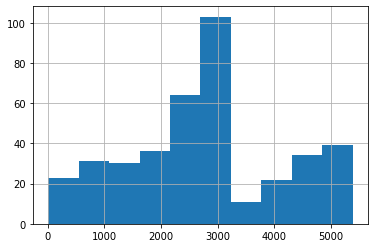

In [ ]:
X_train.describe().iloc[0].hist()

In [ ]:
X_train.shape

(5390, 395)

## Depuración de datos

### Tunning Train

In [ ]:
# Reemplazando [cat_zona1] con sus ocurrencias
cat_zona1 = (X_train["cat_zona1"].value_counts()/X_train["cat_zona1"].count()).to_dict()
X_train.replace(cat_zona1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
# Creando Dummies para [tipo_cliente]
d_tipo = pd.get_dummies(X_train["tipo_cliente"])

In [ ]:
# Uniendo las nuevas variables Dummy a la base total
X_train = X_train.drop(["tipo_cliente"], axis=1).merge(d_tipo, left_index=True, right_index=True)

In [ ]:
# Completando los missing values con la moda
#X_train_prepared = X_train.fillna(X_train.mode().iloc[0])
X_train_prepared = X_train.fillna(X_train.median())
#X_train_prepared = X_train.fillna(X_train.mean())

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler().fit_transform(X_train_prepared.values)
X_train_prepared = pd.DataFrame(sc, index=X_train_prepared.index, columns=X_train_prepared.columns)

### Balanced

In [ ]:
base = X_train_prepared.merge(y_train, left_index=True, right_index=True)

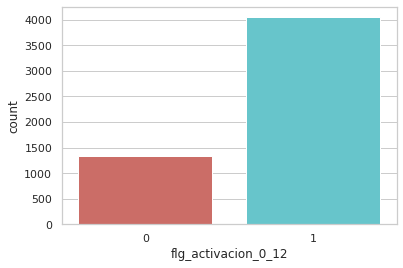

In [ ]:
import seaborn as sns

sns.set(style = "white")
sns.set(style = "whitegrid", color_codes = True)
sns.countplot(x = "flg_activacion_0_12", data = base, palette = 'hls')

In [ ]:
# Oversampling 

from sklearn.utils import resample
# Separate majority and minority classes
df_majority = base[base["flg_activacion_0_12"]==1]
df_minority = base[base["flg_activacion_0_12"]==0]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=base["flg_activacion_0_12"].value_counts()[1],    # to match majority class
                                 random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
base = pd.concat([df_majority, df_minority_upsampled])

In [ ]:
# Undersampling 

from sklearn.utils import resample
# Separate majority and minority classes
df_majority = base[base["flg_activacion_0_12"]==1]
df_minority = base[base["flg_activacion_0_12"]==0]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=base["flg_activacion_0_12"].value_counts()[0],     # to match minority class
                                 random_state=42) # reproducible results
 
# Combine minority class with downsampled majority class
base = pd.concat([df_majority_downsampled, df_minority])
 

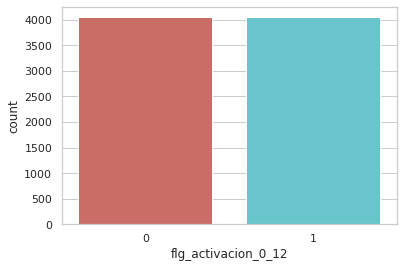

In [ ]:
sns.countplot(x = "flg_activacion_0_12", data = base, palette = 'hls')

In [ ]:
X_train_prepared = base.drop(["flg_activacion_0_12"], axis = 1)
y_train = base["flg_activacion_0_12"].copy()

In [ ]:
X_train_prepared.shape

(8100, 397)

### Tunning Test

In [ ]:
# Reemplazando [cat_zona1] con las ocurrencias de Train en Test
X_test.replace(cat_zona1, inplace=True)

# Dummies
d_tipo = pd.get_dummies(X_test["tipo_cliente"])
X_test = X_test.drop(["tipo_cliente"], axis=1).merge(d_tipo, left_index=True, right_index=True)

# Missing - Mantenemos la moda de Test Set
#X_test_prepared = X_test.fillna(X_train.mode().iloc[0]) 
X_test_prepared = X_test.fillna(X_train.median()) 

# Feature Scaling Test
sc = StandardScaler().fit_transform(X_test_prepared.values)
X_test_prepared = pd.DataFrame(sc, index=X_test_prepared.index, columns=X_test_prepared.columns)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


# Select and Train a Model

## Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, plot_confusion_matrix

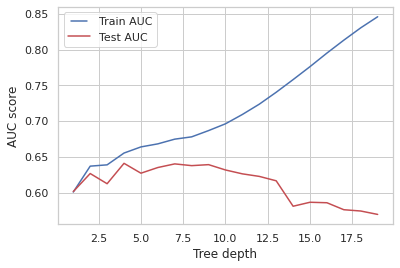

In [ ]:
from sklearn.metrics import roc_curve, auc
#max_depths = np.linspace(1, 32, 32, endpoint=True)
max_depths = [i for i in range(1,20)]
train_results = []
test_results = []
for max_depth in max_depths:
  dt = DecisionTreeClassifier(max_depth=max_depth, class_weight='balanced')
  dt.fit(X_train_prepared, y_train)
  train_pred = dt.predict(X_train_prepared)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  # Add auc score to previous train results
  train_results.append(roc_auc)
  y_pred = dt.predict(X_test_prepared)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  # Add auc score to previous test results
  test_results.append(roc_auc)

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

In [ ]:
[i for i in zip(max_depths, train_results, test_results)]

[(1, 0.6006684959007411, 0.6012973504110214),
 (2, 0.6368979946351706, 0.6265712598145582),
 (3, 0.6387292651215977, 0.6122970468355733),
 (4, 0.655249380826682, 0.6408548468745465),
 (5, 0.6638309343031958, 0.6270375093735036),
 (6, 0.6681090574828132, 0.6349780934696847),
 (7, 0.6746977924247216, 0.6400588131025419),
 (8, 0.6779241843624411, 0.6376167866966342),
 (9, 0.6866830218994493, 0.6390059626045981),
 (10, 0.6961930279965465, 0.6315559780882994),
 (11, 0.7092650071024154, 0.6261169562055445),
 (12, 0.7236776656803818, 0.6225525141861382),
 (13, 0.7403540688707685, 0.6163815758660163),
 (14, 0.75807230235236, 0.5807766942414992),
 (15, 0.7762411067285938, 0.5863489879106664),
 (16, 0.7952141669288785, 0.5856651561522669),
 (17, 0.8133093259817938, 0.5758952651852534),
 (18, 0.830579157438078, 0.5740886574543062),
 (19, 0.8460808499276586, 0.569324169496999)]

In [ ]:
tree_clf = DecisionTreeClassifier(max_depth=7, random_state=0) #, class_weight='balanced'
tree_clf.fit(X_train_prepared, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data

dot_data = export_graphviz(tree_clf ,
                           feature_names = X_train_prepared.columns, 
                           filled=True, 
                           rounded=True, 
                           special_characters=True,
                           class_names= ["No Activó", "Sí Activó"]
                          )

graph = graph_from_dot_data(dot_data)
graph.write_png("tree_tc.png")
print(graph)

Accuracy: 0.6848484848484848
Sensitivity o Recall:  0.8461095100864553
Specificity:  0.19826086956521738
Precision:  0.7610160705028512


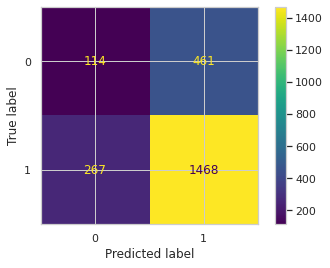

In [ ]:
y_pred_class = tree_clf.predict(X_test_prepared)
confusion = confusion_matrix(y_test, y_pred_class)
TP = confusion[1,1]
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]

#print(confusion)
plot_confusion_matrix(tree_clf, X_test_prepared, y_test, values_format='.0f')

accuracy = accuracy_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
specificity = TN/(TN+FP)
precision = precision_score(y_test, y_pred_class)

print("Accuracy:", accuracy)
#print("Gini: ", (2*auc - 1))
print("Sensitivity o Recall: ",recall)
print("Specificity: ", specificity)
print("Precision: ", precision)

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

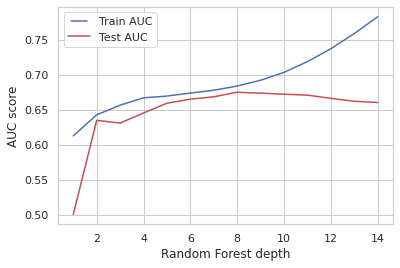

In [ ]:
from sklearn.metrics import roc_curve, auc
max_depths = [i for i in range(1,15)]
train_results = []
test_results = []
for max_depth in max_depths:
  rf = RandomForestClassifier(max_depth=max_depth, class_weight='balanced')
  rf.fit(X_train_prepared, y_train)
  train_pred = rf.predict(X_train_prepared)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  # Add auc score to previous train results
  train_results.append(roc_auc)
  y_pred = rf.predict(X_test_prepared)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  # Add auc score to previous test results
  test_results.append(roc_auc)

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Random Forest depth')
plt.show()

In [ ]:
[i for i in zip(max_depths, train_results, test_results)]

[(1, 0.6128142987632192, 0.500349068958865),
 (2, 0.6429111837614632, 0.6350221841428274),
 (3, 0.6566746746778866, 0.6311170990488343),
 (4, 0.6672502841335054, 0.645538626743774),
 (5, 0.6697540120864429, 0.6595082043950781),
 (6, 0.6740999378569249, 0.665288050955663),
 (7, 0.6780813621290308, 0.6687559265577779),
 (8, 0.6841222474877646, 0.6752625825181804),
 (9, 0.6924328891821029, 0.6739151272661197),
 (10, 0.7036488485628792, 0.67244402488316),
 (11, 0.7191384512417819, 0.6711045218915879),
 (12, 0.7374684730068906, 0.6665080210473046),
 (13, 0.759198262598076, 0.6623565626793904),
 (14, 0.7833150336983252, 0.660546808846263)]

In [ ]:
rfc = RandomForestClassifier(n_estimators=100,
                             class_weight='balanced',
                             max_depth = 5,
                             #oob_score=True, # out of bagging
                             verbose=0, # c/arbol ejecutado arrojará un resultado que se mostrará
                             n_jobs=-1, # = -1 para paralelizar el conj. de árboles 
                             random_state=0)
rfc = rfc.fit(X_train_prepared, y_train)

Accuracy: 0.7164502164502164
Sensitivity o Recall:  0.9146974063400576
Specificity:  0.11826086956521739
Precision:  0.7578796561604585


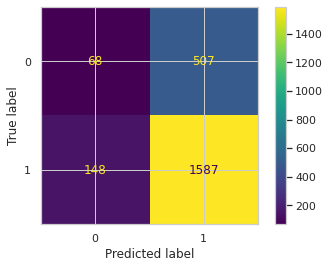

In [ ]:
y_pred_class = rfc.predict(X_test_prepared)
confusion = confusion_matrix(y_test, y_pred_class)
TP = confusion[1,1]
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]

#print(confusion)
plot_confusion_matrix(rfc, X_test_prepared, y_test, values_format='.0f')

accuracy = accuracy_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
specificity = TN/(TN+FP)
precision = precision_score(y_test, y_pred_class)

print("Accuracy:", accuracy)
#print("Gini: ", (2*auc - 1))
print("Sensitivity o Recall: ",recall)
print("Specificity: ", specificity)
print("Precision: ", precision)

## Importancias 

In [ ]:
# Decision Tree Classifier
for a, b  in zip(X_train_prepared.columns, tree_clf.feature_importances_):
    if b > 0:
        print(a,":", b) 

rt_evol_nhi_3_6 : 0.011063967166131238
meses_pmsavmf_24_1000 : 0.02629978716040235
rt_fmsavmf_sum_1_24 : 0.011396372226246862
rt_pmsavmf_min_24_24 : 0.0034949667848759537
rt_pmsavmf_max_min_24_24 : 0.006536041779508277
rt_fm_pmsavmf_sum_24_24 : 0.010635582752414935
rt_mtocns_min_2_24 : 0.01677445543929656
cons_decsldfm : 0.012322519369542479
rt_cnop_max_6_12 : 0.01725024181681864
rt_mtcoetmxcn100f_max_6_12 : 0.009394578670388565
rt_cnetcnpscl_d_max_6_12 : 0.0034949667848759537
rt_mxmtdia02r_max_6_12 : 0.034210239426976125
rt_cnetigcl_1k3f_sum_6_6 : 0.01775960899574002
rt_cnetmtco_d_sum_12_12 : 0.01447569613475424
rt_cnetmtco_e_sum_12_12 : 0.015955283148346745
rt_cnetmtfac6m_e_sum_12_12 : 0.0039298244032706575
md_min_12 : 0.0287810206781778
prcnpsclet_med_12 : 0.007126915537395955
mdigclet_02r_med_12 : 0.026717638751752062
mt_06t_sum_12 : 0.01610203894492431
prmtcoet_06t_min_12 : 0.009578833416167819
prcnpsclet_med_6 : 0.0038463126521386137
prcnpsclet_11t_min_12 : 0.019322984909863
mdig

In [ ]:
# Random Forest Classifier
for a, b  in zip(X_train_prepared.columns, rfc.feature_importances_):
    #if b > 0:
        print(a, ":", b)

xb_buro : 0.0026188950556328815
cl_veh_mean_st : 0.00048513072659785427
cat_zona1 : 0.003614646310181523
atr_co_med_24 : 0.0003543891432652821
dist_ult1_atr_co_24_0_100 : 0.0002842530942928034
rt_bal_co_med_3_6 : 0.002602324463655692
rt_atr_co_max_3_12 : 0.0
rt_atr_co_max_3_24 : 0.0
atr_hi_max_3_0 : 0.0
dist_ult1_atr_hi_24_0_0 : 0.0
rt_bal_hi_med_3_12 : 0.0008097271797899952
rt_bal_hi_med_6_12 : 0.0016915473592271182
num_tc_min_24 : 0.0008976722774539577
num_tc_sum_24 : 0.004235349737032846
lincre_tc_max_24 : 0.008048411909833204
lincre_tc_sum_24 : 0.009711215619311235
flagpr_tc_sum_12 : 0.0
atr_tc_med_12 : 8.363660766914711e-05
bal_tc_min_12 : 0.0029060608769511083
atr_tc_min_3 : 0.0
dist_primer_atr_tc_24_0 : 0.00046979189715013923
rt_atr_tc_max_6_24 : 0.0
rt_bal_tc_med_12_24 : 0.0019905645220279398
atr_max_3 : 0.0
atr_max_3_300 : 0.0
atr_max_12_300 : 0.00010500235626231077
atr_max_24_300 : 0.0009614444115561407
atr_min_6_300 : 0.0
bal_nhi_sum_12 : 0.0032407294242012778
varied_prod_24

In [ ]:
import matplotlib.pyplot as plt
def plot_feature_importances_tc(model):
    n_features = len(X_train_prepared.columns)
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train_prepared.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

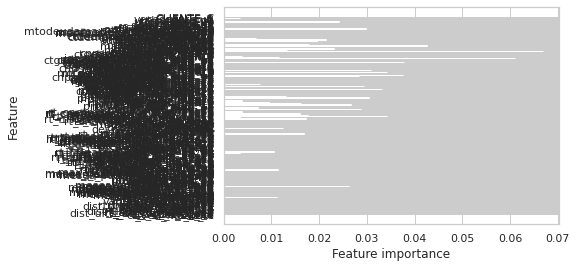

In [ ]:
plot_feature_importances_tc(tree_clf)

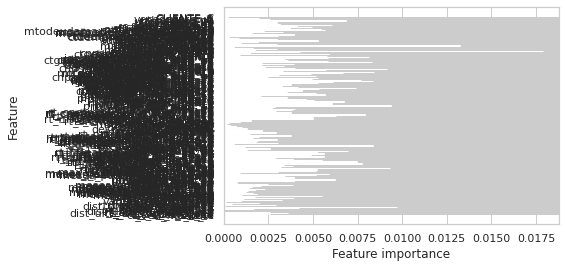

In [ ]:
plot_feature_importances_tc(rfc)

## SVM Classifier

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC(class_weight='balanced', probability=True) 
svm_clf.fit(X_train_prepared, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

Accuracy: 0.6095238095238096
Sensitivity o Recall:  0.7198847262247838
Specificity:  0.27652173913043476
Precision:  0.7501501501501502


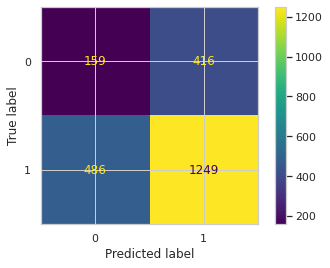

In [ ]:
y_pred_class = svm_clf.predict(X_test_prepared)
confusion = confusion_matrix(y_test, y_pred_class)
TP = confusion[1,1]
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]

#print(confusion)
plot_confusion_matrix(svm_clf, X_test_prepared, y_test, values_format='.0f')

accuracy = accuracy_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
specificity = TN/(TN+FP)
precision = precision_score(y_test, y_pred_class)

print("Accuracy:", accuracy)
#print("Gini: ", (2*auc - 1))
print("Sensitivity o Recall: ",recall)
print("Specificity: ", specificity)
print("Precision: ", precision)

## XGBoost

In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train_prepared, label=y_train)
dtest = xgb.DMatrix(X_test_prepared, label=y_test)

In [ ]:
param = {
    'max_depth': 4,  # the maximum depth of each tree
    'learning_rate' : 0.3,
    #'silent': 1,  # logging mode - quiet
    #'objective': 'multi:softprob',  # error evaluation for multiclass training
    'objetive' : 'binary_logistic',
    'eval_metric' : 'auc',
    #'num_class': 3
    #'min_child_weight' : 4,
    #'min_data_leaf' : 300,
    #'class_weight' : 'balanced',
    'grow_policy' : 'lossguide'
    }  # the number of classes that exist in this datset
num_round = 30  # the number of training iterations

In [ ]:
xgBoost = xgb.train(param, dtrain, num_round)
preds = xgBoost.predict(dtest)

cf = confusion_matrix(y_test,(preds>0.5))
print("accuracy:", accuracy_score(y_test, preds>0.5))
print("precision:", precision_score(y_test, preds>0.5))
print("specificity:",cf[0,0]/(cf[0,0]+cf[0,1]))
print("Sensitivity o Recall: ",recall_score(y_test, preds>0.5))
print("**False Positive Rate:",1-(cf[0,0]/(cf[0,0]+cf[0,1])))

accuracy: 0.6012987012987013
precision: 0.7622422680412371
specificity: 0.3582608695652174
Sensitivity o Recall:  0.6818443804034582
**False Positive Rate: 0.6417391304347826


### Funcion plot_roc_curve

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import auc, roc_curve

def plot_roc_curve(y_true, y_score, filepath=None, line_width=2, width=12,
                   height=10, title=None, colors=("#FF0000", "#000000")):
    """
    Saves a ROC curve in a file or shows it on screen.
    :param y_true: actual values of the response (list|np.array)
    :param y_score: predicted scores (list|np.array)
    :param filepath: if given, the ROC curve is saved in the desired filepath. It should point to a png file in an
    existing directory. If not specified, the curve is only shown (str)
    :param line_width: number indicating line width (float)
    :param width: number indicating the width of saved plot (float)
    :param height: number indicating the height of saved plot (float)
    :param title: if given, title to add to the top side of the plot (str)
    :param colors: color specification for ROC curve and diagonal respectively (tuple of str)
    :return: None
    """
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_score)
    gini = auc(fpr, tpr) * 2 - 1

    sns.set_style("whitegrid")
    fig = plt.figure(figsize=(width, height))
    major_ticks = np.arange(0, 1.1, 0.1)
    minor_ticks = np.arange(0.05, 1, 0.1)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which="both", axis="both")
    ax.grid(which="minor", alpha=0.2)
    ax.grid(which="major", alpha=0.5)
    ax.tick_params(which="major", direction="out", length=5)
    plt.plot(fpr, tpr, color=colors[0], lw=line_width,
                   label="ROC curve (gini = {:.2f})".format(gini))
    plt.plot([0, 1], [0, 1], color=colors[1], lw=line_width, linestyle='--')
    plt.xlim([-0.001, 1.001])
    plt.ylim([-0.001, 1.001])
    plt.xlabel("False positive rate", fontsize=15)
    plt.ylabel("True positive rate", fontsize=15)
    if title:
        plt.title(title, fontsize=30, loc="left")
    plt.legend(loc="lower right", frameon=True, fontsize="xx-large",
                     fancybox=True)
    plt.tight_layout()
    if filepath:
        plt.savefig(filepath, dpi=200)
        plt.close()
    else:
        plt.show()

### Metrics XGBoost

In [ ]:
y_pred_train = xgBoost.predict(xgb.DMatrix(X_train_prepared, label = y_train))
y_pred_test = xgBoost.predict(xgb.DMatrix(X_test_prepared, label = y_test))

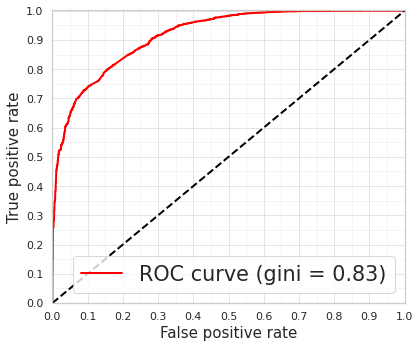

In [ ]:
plot_roc_curve(y_train, y_pred_train, width=6, height=5)

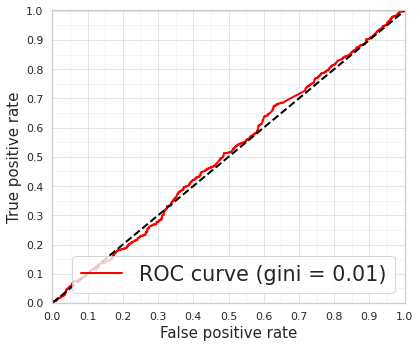

In [ ]:
plot_roc_curve(y_test, y_pred_test, width=6, height=5)

### Importancias XGBoost

In [ ]:
importance = xgBoost.get_score(importance_type='total_gain')

In [ ]:
importance

{'CLIENTE_B': 3.3131423,
 'antiguedad_act_vig': 16.261795760000002,
 'antiguedad_pas_tot': 0.00460958481,
 'atr_co_med_24': 2.40082908,
 'atr_tc_med_12': 2.14214635,
 'atrasomax_crneg_12': 9.19127059,
 'bal_nhi_sum_12': 0.5699036125000001,
 'bal_tc_min_12': 0.02459359166,
 'cat_zona1': 2.1391022939,
 'cl_veh_mean_st': 2.8619439609999997,
 'cnetigcl_1k3f_max_12': 1.69836235,
 'cnfecmxmt_med_6': 3.77703762,
 'cnop_16b_med_12': 1.64680862,
 'cnpscletmxcn100f_min_12': 7.04238605,
 'cnpscletmxcn50f_med_12': 3.38071489,
 'cnpscletmxcn_med_6': 2.70993495,
 'cnpscletmxcnfds07v_med_12': 3.5235424,
 'cnpscletmxmt_max_6': 3.89362288,
 'cnpscletmxmtop05s_min_12': 10.065935849999999,
 'cnpscletmxmtop_max_12': 1.77545798,
 'cnpscletmxmtop_med_6': 6.10501671,
 'cnpscletmxmtop_sum_12': 3.77127647,
 'cons_decmt_17m': 3.48047733,
 'cons_incmt_02r': 6.10356569,
 'cons_incmt_11t': 7.98277783,
 'ctamin_min_12': 0.610724211,
 'ctdempreportadoclimed24': 3.24066162,
 'ctdempreportadoclimed6': 1.60449123,
 'ct

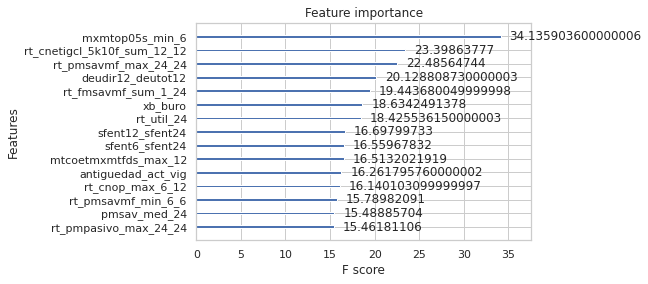

In [ ]:
xgb.plot_importance(xgBoost, max_num_features=15, importance_type='total_gain')

In [ ]:
pdVarImp = pd.DataFrame({'Feature': list(importance.keys()),
                         'Importance': list(importance.values())}).sort_values('Importance', ascending = False)

pdVarImp['C'] = np.arange(len(pdVarImp)) + 1
pdVarImp

,Feature,Importance,C
5,mxmtop05s_min_6,34.135904,1
13,rt_cnetigcl_5k10f_sum_12_12,23.398638,2
31,rt_pmsavmf_max_24_24,22.485647,3
70,deudir12_deutot12,20.128809,4
71,rt_fmsavmf_sum_1_24,19.443680,5
...,...,...,...
91,meses_fmpasivo_6_0,0.409426,210
179,mtfecmxcn_max_12,0.198957,211
88,dist_ult1_atr_hi_24_0_0,0.104149,212
141,bal_tc_min_12,0.024594,213


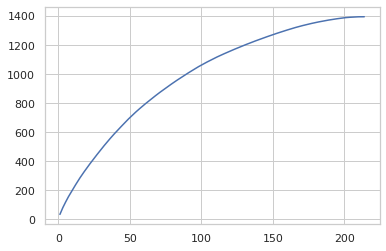

In [ ]:
plt.plot(pdVarImp.C, pdVarImp.Importance.cumsum(axis=0))

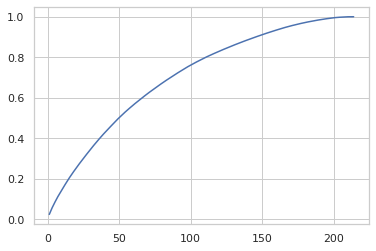

In [ ]:
pdVarImp['porc_gain'] = pdVarImp.Importance.apply(lambda x: x/pdVarImp.Importance.sum())
plt.plot(pdVarImp.C, pdVarImp.porc_gain.cumsum(axis=0))

In [ ]:
pdVarImp['porc_gain_acum'] = pdVarImp.porc_gain.cumsum(axis=0)

In [ ]:
pdVarImp.transpose()

,5,13,31,70,71,29,20,58,56,1,73,68,38,164,65,46,14,113,0,66,7,25,105,19,16,15,130,148,35,143,74,52,121,115,149,85,97,44,18,33,...,154,213,209,181,101,128,207,169,87,190,151,172,168,195,28,131,142,206,171,127,132,107,26,61,152,186,156,123,155,208,129,93,108,147,89,91,179,88,141,72
Feature,mxmtop05s_min_6,rt_cnetigcl_5k10f_sum_12_12,rt_pmsavmf_max_24_24,deudir12_deutot12,rt_fmsavmf_sum_1_24,xb_buro,rt_util_24,sfent12_sfent24,sfent6_sfent24,mtcoetmxmtfds_max_12,antiguedad_act_vig,rt_cnop_max_6_12,rt_pmsavmf_min_6_6,pmsav_med_24,rt_pmpasivo_max_24_24,prmtcoet_06t_min_12,igcletmxcnfds_min_6,montoade_act3_max6_s_hip,max_mt_09dmax,rt_fmsavmf_max_12_12,mtototdeu_d_i_pro3,rt_mxmtdia02r_max_6_12,rt_pmsavmf_min_24_24,maxcons_incmt_02r,rt_cnetigcl_e_max_6_12,mt_06t_sum_12,pr_02r_sum_12,mt_min_6,rt_fmactivo_max_6_6,rt_pmsavmf_max_min_24_24,rt_cnetmtco_e_sum_12_12,rt_fm_pmsavmf_sum_24_24,mtcoetmxcn_med_12,pr_05s_sum_12,rt_fmsavmf_max_min_12_12,rt_fmactivo_sum_12_24,rt_pmpas_pmact_6_6,igcletmxcn100f_max_12,igcletmxmt_med_6,mtcoetmxcnfds_med_12,...,atr_co_med_24,rt_util_max_24,prcnpsclet_11t_min_12,rt_pagos_balance,atr_tc_med_12,cat_zona1,pmpasivo_min_24,maxantiguedad_act_pas_vig,rt_cnetmtfac6m_e_sum_12_12,prigclet_07v_med_6,fmjud_count_24,utl1_utl24_tc,deudir24_deutot24,cnpscletmxmtop_max_12,cnetigcl_1k3f_max_12,cnop_16b_med_12,rt_mtpgos_sldfm_med_6_6,ctdempreportadoclimed6,sf1_sf24_ind_s_hip,rt_mtocns_sldfm_max_24_24,prigclet_max_12,rt_mtodisef_sldfm_min_2_12,meses_fmpasivo_12_100,prigclet_14s_med_6,mtdsmxcn_min_12,rt_evol_rev_3_6,rt_fmvj_sum_24_24,linea_min_2,rt_pmpasivo_max_6_12,ctamin_min_12,rt_bal_tc_med_12_24,fmcts_min_12,bal_nhi_sum_12,mdigclet_02r_med_12,rt_util_3,meses_fmpasivo_6_0,mtfecmxcn_max_12,dist_ult1_atr_hi_24_0_0,bal_tc_min_12,antiguedad_pas_tot
Importance,34.1359,23.3986,22.4856,20.1288,19.4437,18.6342,18.4255,16.698,16.5597,16.5132,16.2618,16.1401,15.7898,15.4889,15.4618,14.6985,14.1764,14.1462,13.8436,13.7559,13.4126,13.1641,13.057,12.9123,12.8855,12.6447,12.5608,12.5549,12.4849,12.3781,12.186,12.0849,11.8527,11.7106,11.6149,11.431,11.3445,11.1034,10.9645,10.6303,...,2.40083,2.25623,2.21055,2.2067,2.14215,2.1391,2.05599,1.96687,1.93929,1.87365,1.86256,1.84085,1.8321,1.77546,1.69836,1.64681,1.62159,1.60449,1.4892,1.46419,1.42084,1.38226,1.37861,1.3321,1.32955,1.21876,1.07255,0.960645,0.822359,0.610724,0.607314,0.600694,0.569904,0.564958,0.521504,0.409426,0.198957,0.104149,0.0245936,0.00460958
C,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214
porc_gain,0.0244561,0.0167635,0.0161094,0.0144209,0.0139301,0.0133502,0.0132006,0.011963,0.0118639,0.0118306,0.0116505,0.0115633,0.0113123,0.0110967,0.0110773,0.0105305,0.0101564,0.0101348,0.009918,0.00985514,0.00960921,0.00943116,0.00935448,0.00925081,0.00923157,0.00905908,0.00899898,0.00899475,0.00894455,0.00886804,0.00873047,0.00865799,0.00849165,0.00838984,0.00832126,0.0081895,0.00812753,0.00795484,0.00785532,0.00761591,...,0.00172003,0.00161644,0.00158371,0.00158095,0.0015347,0.00153252,0.00147298,0.00140913,0.00138937,0.00134234,0.0013344,0.00131884,0.00131258,0.00127199,0.00121676,0.00117983,0.00116176,0.00114951,0.00106691,0.00104899,0.00101794,0.000990293,0.000987678,0.000954359,0.000952531,0.000873156,0.000768412,0.000688237,0.000589164,0.000437542,0.000435099,0.000430356,0.000408297,0.000404754,0.000373622,0.000293326,0.000142539,7.46155e-05,1.76196e-05,3.30245e-06
porc_gain_acum,0.0244561,0.0412196,0.057329,0.0717499,0.08568,0.0990302,0.112231,0.124194,0.136058,0.147888,0.159539,0.171102,0.182414,0.193511,0.204588,0.215119,0.225275,0.23541,0.245328,0.255183,0.264792,0.274224,0.283578,0.292829,0.30206,0.31112,0.320118,0.329113,0.338058,0.346926,0.355656,0.364314,0.372806,0.381196,0.389517,0.397707,0.405834,0.413789,0.421644,0.42926,...,0.963633,0.9652

## Cross Validation

In [ ]:
import numpy as np
import time
dtrain = xgb.DMatrix(X_train_prepared, label = y_train)
dtest = xgb.DMatrix(X_test_prepared, label = y_test)
param = {
    'max_depth': 4,  # the maximum depth of each tree
    'learning_rate' : 0.3,
    #'eta': 0.3,  # the training step for each iteration
    #'silent': 1,  # logging mode - quiet
    #'objective': 'multi:softprob',  # error evaluation for multiclass training
    'objetive' : 'binary_logistic',
    'eval_metric' : 'auc',
    #'num_class': 3
    #'class_weight' : 'balanced',
    'grow_policy' : 'lossguide'
    }  # the number of classes that exist in this datset
num_round = 100  # the number of training iterations

n_folds=3
early_stopping=10

start_time = time.time()
xgBoost = xgb.cv(param, dtrain,
               num_round,
               nfold = n_folds,
               early_stopping_rounds = early_stopping,
               verbose_eval = 1)
print("----%s seconds ----" %(time.time() - start_time))

[0]	train-auc:0.582345+0.00508853	test-auc:0.542701+0.00611416
[1]	train-auc:0.626594+0.0228788	test-auc:0.561045+0.0143243
[2]	train-auc:0.663557+0.0118325	test-auc:0.585915+0.00815144
[3]	train-auc:0.696817+0.00830265	test-auc:0.606865+0.00730362
[4]	train-auc:0.724545+0.0111756	test-auc:0.620367+0.0119972
[5]	train-auc:0.738763+0.0118866	test-auc:0.627692+0.0137926
[6]	train-auc:0.762484+0.00869929	test-auc:0.642645+0.010087
[7]	train-auc:0.777415+0.00142054	test-auc:0.6504+0.00949166
[8]	train-auc:0.791777+0.00381411	test-auc:0.658221+0.00820068
[9]	train-auc:0.802377+0.00206132	test-auc:0.669355+0.00873506
[10]	train-auc:0.813867+0.00484202	test-auc:0.680603+0.0136314
[11]	train-auc:0.825374+0.00487046	test-auc:0.688329+0.0118577
[12]	train-auc:0.838691+0.00372903	test-auc:0.699281+0.00801981
[13]	train-auc:0.849251+0.00302543	test-auc:0.702432+0.0117384
[14]	train-auc:0.85683+0.00540891	test-auc:0.710495+0.0108069
[15]	train-auc:0.863667+0.0052947	test-auc:0.717645+0.00948631
[16

AxesSubplot(0.125,0.125;0.775x0.755)


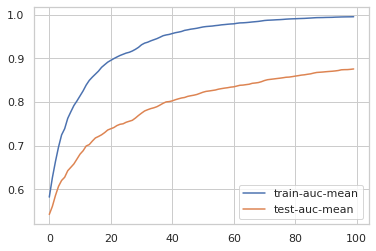

In [ ]:
lines = xgBoost[['train-auc-mean', 'test-auc-mean']].plot.line()
print(lines)

In [ ]:
num_round = 30
n_folds = 3

parametersCV = [2,3,4,5,6,7,8,9,10]
train_auc = []
test_auc = []

start_time = time.time()
for i in parametersCV:
  param['max_depth'] = i
  xgBoost = xgb.cv(param, dtrain, num_round, nfold=n_folds)
  print(str(i))
print("---- %s seconds ---" %(time.time()-start_time))

2
3
4
5
6
7
8
9
10
---- 82.52690768241882 seconds ---


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=0.01, max_iter=500, class_weight='balanced')
lr.fit(X_train_prepared, y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy: 0.5393939393939394
Sensitivity o Recall:  0.5948126801152738
Specificity:  0.37217391304347824
Precision:  0.7408470926058865


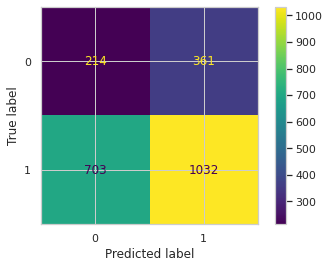

In [ ]:
y_pred_class = lr.predict(X_test_prepared)
confusion = confusion_matrix(y_test, y_pred_class)
TP = confusion[1,1]
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]

#print(confusion)
plot_confusion_matrix(lr, X_test_prepared, y_test, values_format='.0f')

accuracy = accuracy_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
specificity = TN/(TN+FP)
precision = precision_score(y_test, y_pred_class)

print("Accuracy:", accuracy)
#print("Gini: ", (2*auc - 1))
print("Sensitivity o Recall: ",recall)
print("Specificity: ", specificity)
print("Precision: ", precision)

## Redes Neuronales - TensorFlow

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score

In [ ]:
lrate = 0.001
batch_size = 640
epochs = 1000

#Define Model
model = tf.keras.models.Sequential([tf.keras.layers.Dense(140, input_dim=397, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(70,  activation=tf.nn.relu),
                                    tf.keras.layers.Dense(35,  activation=tf.nn.relu),
                                    tf.keras.layers.Dense(5,   activation=tf.nn.relu),
                                    tf.keras.layers.Dense(1,   activation=tf.nn.sigmoid)])

# compile model
model.compile(optimizer = tf.optimizers.SGD(learning_rate=lrate),
              loss = 'BinaryCrossentropy',
              metrics=[tf.keras.metrics.AUC()])
    
early_stopping_cb = EarlyStopping(patience=10, verbose=1)

# fit model
history = model.fit(X_train_prepared, y_train, 
                    epochs = epochs, batch_size = batch_size, shuffle=True,
                    validation_data = (X_test_prepared, y_test),
                    callbacks = [early_stopping_cb],
                    use_multiprocessing = True)

Epoch 1/1000
13/13 [==============================] - 1s 42ms/step - loss: 0.7014 - auc: 0.4962 - val_loss: 0.7284 - val_auc: 0.4988
Epoch 2/1000
13/13 [==============================] - 0s 22ms/step - loss: 0.7011 - auc: 0.4962 - val_loss: 0.7280 - val_auc: 0.4980
Epoch 3/1000
13/13 [==============================] - 0s 23ms/step - loss: 0.7010 - auc: 0.4964 - val_loss: 0.7276 - val_auc: 0.4991
Epoch 4/1000
13/13 [==============================] - 0s 22ms/step - loss: 0.7009 - auc: 0.4969 - val_loss: 0.7273 - val_auc: 0.4992
Epoch 5/1000
13/13 [==============================] - 0s 23ms/step - loss: 0.7010 - auc: 0.4980 - val_loss: 0.7269 - val_auc: 0.4993
Epoch 6/1000
13/13 [==============================] - 0s 21ms/step - loss: 0.7005 - auc: 0.4985 - val_loss: 0.7266 - val_auc: 0.4996
Epoch 7/1000
13/13 [==============================] - 0s 22ms/step - loss: 0.7008 - auc: 0.4988 - val_loss: 0.7262 - val_auc: 0.4991
Epoch 8/1000
13/13 [==============================] - 0s 23ms/step - 

In [ ]:
y_pred = model.predict_classes(X_test_prepared)

y_pred_prob = model.predict(X_test_prepared)
y_pred_prob_train = model.predict(X_train_prepared)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
print("Train:",roc_auc_score(y_train, y_pred_prob_train)*2-1)
print(" Test:", roc_auc_score(y_test, y_pred_prob)*2-1)

Train: 0.3890356348117665
 Test: 0.015880716702167508


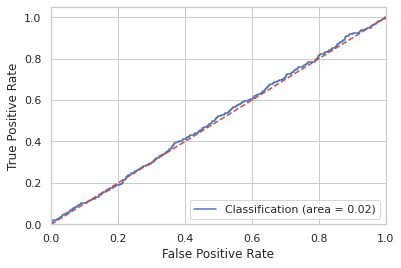

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt


logit_roc_auc = roc_auc_score(y_test, y_pred_prob)*2-1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, label='Classification (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

## Modelo Final

### XGBoost GPU

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, plot_confusion_matrix
from xgboost import XGBClassifier
import time

In [ ]:
start_time = time.time()
model = XGBClassifier(eval_metric = 'auc',
                      grow_policy = 'lossguide',
                      learning_rate = 0.3,
                      max_depth = 4,
                      min_data_leaf = 3000,
                      objetive = 'binary_logistic',
                      seed = 42,
                      num_round = 30,

                      tree_method = 'gpu_hist',
                      nthread = -1
                      )
model = model.fit(X_train_prepared, y_train)
elapsed = time.time() - start_time
print("GPU  XGBoost: %f" %(elapsed))

GPU  XGBoost: 1.459195


Accuracy: 0.641991341991342
Sensitivity o Recall:  0.7780979827089337
Specificity:  0.23130434782608697
Precision:  0.7533482142857143


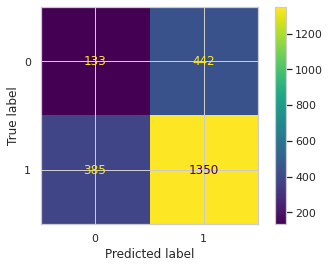

In [ ]:
y_pred_class = model.predict(X_test_prepared)
confusion = confusion_matrix(y_test, y_pred_class)
TP = confusion[1,1]
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]

#print(confusion)
plot_confusion_matrix(model, X_test_prepared, y_test, values_format='.0f')

accuracy = accuracy_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
specificity = TN/(TN+FP)
precision = precision_score(y_test, y_pred_class)

print("Accuracy:", accuracy)
print("Sensitivity o Recall: ",recall)
print("Specificity: ", specificity)
print("Precision: ", precision)

## Aplicaciones del modelo
### Incremento de ratio de efectividad

Elaboramos la distribución de probabilidades del modelo propuesto para la muestra de validacion, se puede apreciar que aproximadamente se concentra en 70%, siendo actualmente de 40% según dato del problema. Por lo tanto podemos identificar un segmento de personas sobre quienes podríamos incrementar las colocaciones.

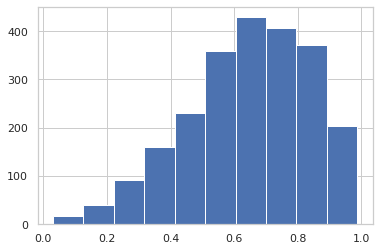

In [ ]:
x = model.predict_proba(X_test_prepared) 
df_x = pd.DataFrame(x, columns=[0, 1])
df_x[1].hist()

## Fin

In [ ]:
datafest